In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft

expts = ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]
# client = tt.startdask()
# client

# Load in the stuff we saved earlier!


In [2]:
expt = "full-20"


data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
    path = Path(f"/scratch/nm03/ab8992/test/outputs") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    data[expt] = xr.merge(
    [
        xr.open_dataset(path / "dissipation_modal.nc"),
        xr.open_dataset(path / "raw_dissipation.nc"),
        xr.open_dataset(path / "filtered_dissipation.nc"),
        xr.open_dataset(path / "filtered_ke_total.nc"),
        xr.open_dataset(path / "filtered_ke_bt.nc"),
        xr.open_dataset(path / "raw_ke_bt.nc"),
        xr.open_dataset(path / "raw_ke_total.nc"),
        xr.open_dataset(path / "ke_modal.nc"),
        xr.open_dataset(path / "EF_forward.nc"),
        xr.open_dataset(path / "EF_backward.nc"),
        xr.open_dataset(path / "raw_vorticity.nc"),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).sel(xb = slice(0,1200))



## Plot KE composition

In [5]:
def plot_KE_decomposition(data,expts):
    fig,ax = plt.subplots(3,1,figsize=(20,10))
    
    data[expt].filtered_ke_total.plot
    ax.legend()
    ax.set_title(expt)
    plt.show()

plot_KE_decomposition(data,"full-10")

In [7]:
data["full-10"]

# Plot raw data for every experiment


In [37]:
expt = "full-10"
for expt in expts:
    fig,ax = plt.subplots(4,1,figsize=(20,20))
    data[expt].KE_modal.isel(mode = 0).plot(ax = ax[0])
    data[expt].KE_modal.isel(mode = 1).plot(ax = ax[1])
    # data[expt].filtered_KE_total.plot(ax = ax[1])
    (data[expt].raw_KE_total - data[expt].raw_KE_bt).plot(ax = ax[3],cmap = "viridis",vmin = 0)
    (data[expt].filtered_KE_total - data[expt].filtered_KE_bt).plot(ax = ax[2],cmap = "viridis",vmin = 0)
    # data[expt].raw_KE_bt.plot(ax = ax[3])
    # fig.suptitle(expt + "KE")
    [tt.plot_topo(ax[i],data[expt].bathy) for i in range(4)]
    [ax[i].set_xlabel("") for i in range(3)]
    ax[0].set_title(expt + " Mode 1")
    ax[1].set_title(expt + " Mode 2")
    ax[3].set_title(expt + " Unfiltered Baroclinic")
    ax[2].set_title(expt + "Baroclinic M2 (all modes)")
    [ax[i].collections[0].colorbar.set_label(r"Kinetic Energy  $KJm^{-2}$") for i in range(4)]
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    fig.savefig(path / "KE_decomposition.png")

## Dissipation

In [92]:
expt = "full-10"
for expt in expts:
    # expt = "smooth-40"
    fig,ax = plt.subplots(4,1,figsize=(20,20))
    np.log(1000 * data[expt].dissipation_modal).isel(mode = 0).plot(ax = ax[0],cmap = "cubehelix")
    np.log(1000 * data[expt].dissipation_modal).isel(mode = 1).plot(ax = ax[1],cmap = "cubehelix")
    # data[expt].vorticity.plot(ax = ax[2])
    # data[expt].filtered_KE_total.plot(ax = ax[1])
    np.log(1000 * data[expt].raw_dissipation).plot(ax = ax[3],cmap = "cubehelix")
    np.log(1000 * data[expt].filtered_dissipation).plot(ax = ax[2],cmap = "cubehelix")
    # data[expt].raw_KE_bt.plot(ax = ax[3])
    # fig.suptitle(expt + "KE")
    [tt.plot_topo(ax[i],data[expt].bathy) for i in range(4)]
    [ax[i].set_xlabel("") for i in range(3)]
    ax[0].set_title(expt + " Mode 1")
    ax[1].set_title(expt + " Mode 2")
    ax[3].set_title(expt + " Raw dissipation")
    ax[2].set_title(expt + " M2 filtered dissipation (all modes)")
    [ax[i].collections[0].colorbar.set_label(r"Dissipation  $W m^{-2}$") for i in range(4)]
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    fig.savefig(path / "dissipation_decomposition.png")


## EF per mode


In [14]:
expt = "full-10"
for expt in expts:
    # expt = "smooth-40"
    fig,ax = plt.subplots(2,1,figsize=(20,10))
    (data[expt].bathy).plot(ax = ax[0],cmap = "cubehelix",vmax = 0)
    (data[expt].vorticity).plot(ax = ax[1],cmap = "RdBu_r")


    [tt.plot_topo(ax[i],data[expt].bathy) for i in range(2)]
    [ax[i].set_xlabel("") for i in range(1)]
    ax[0].set_title(expt + " Forward energy flux Mode 1")
    ax[1].set_title(expt + " Forward energy flux Mode 2")

    ax[0].collections[0].colorbar.set_label("Depth (m)")
    ax[1].collections[0].colorbar.set_label("Vorticity (s$^{-1}$)")
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    fig.savefig(path / "depth_vorticity.png")
    # break


In [9]:
expt = "full-10"
for expt in expts:
    # expt = "smooth-40"
    fig,ax = plt.subplots(4,1,figsize=(20,20))
    (data[expt].EF_backward).isel(mode = 0).plot(ax = ax[0],cmap = "RdBu_r")
    (data[expt].EF_backward).isel(mode = 1).plot(ax = ax[1],cmap = "RdBu_r")
    (data[expt].EF_backward).isel(mode = 2).plot(ax = ax[2],cmap = "RdBu_r")
    (data[expt].EF_backward).isel(mode = slice(3,None)).sum("mode").plot(ax = ax[3],cmap = "RdBu_r")
    # data[expt].vorticity.plot(ax = ax[3])

    [tt.plot_topo(ax[i],data[expt].bathy) for i in range(4)]
    [ax[i].set_xlabel("") for i in range(3)]
    ax[0].set_title(expt + " Backward energy flux Mode 1")
    ax[1].set_title(expt + " Backward energy flux Mode 2")
    ax[2].set_title(expt + " Backward energy flux Mode 3")
    ax[3].set_title(expt + " Backward energy flux Rest of modes combined")
    [ax[i].collections[0].colorbar.set_label(r"Energy flux backward $Wm^{-1}") for i in range(4)]
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    fig.savefig(path / "EF_backward.png")
    # break

## Vorticity and raw bathy

In [36]:
expt = "full-10"
for expt in expts:
    # expt = "smooth-40"
    fig,ax = plt.subplots(4,1,figsize=(20,20))
    (data[expt].EF_backward).isel(mode = 0).plot(ax = ax[0],cmap = "RdBu_r")
    (data[expt].EF_backward).isel(mode = 1).plot(ax = ax[1],cmap = "RdBu_r")
    (data[expt].EF_backward).isel(mode = 2).plot(ax = ax[2],cmap = "RdBu_r")
    (data[expt].EF_backward).isel(mode = slice(3,None)).sum("mode").plot(ax = ax[3],cmap = "RdBu_r")
    # data[expt].vorticity.plot(ax = ax[3])

    [tt.plot_topo(ax[i],data[expt].bathy) for i in range(4)]
    [ax[i].set_xlabel("") for i in range(3)]
    ax[0].set_title(expt + " Backward energy flux Mode 1")
    ax[1].set_title(expt + " Backward energy flux Mode 2")
    ax[2].set_title(expt + " Backward energy flux Mode 3")
    ax[3].set_title(expt + " Backward energy flux Rest of modes combined")
    [ax[i].collections[0].colorbar.set_label(r"Energy flux backward $Wm^{-1}") for i in range(4)]
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    # fig.savefig(path / "EF_backward.png")
    # break

## Decompose into bar plots

In [27]:
expt = "full-40"

for expt in expts:
    total_energy = data[expt].raw_KE_total
    shelf_region = slice(0,200)
    beam_region = slice(400,600)
    generation_region = slice(1000,1200)

    # Sample data
    categories = ['Shelf', 'Beam', 'Generation']
    total_energy = np.array([data[expt].raw_KE_total.sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    mode1 = np.array([data[expt].KE_modal.isel(mode = 0).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    mode2 = np.array([data[expt].KE_modal.isel(mode = 1).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    remaining_modes = np.array([data[expt].KE_modal.isel(mode = slice(2,None)).sel(xb = region).sum("mode").mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    barotropic = np.array([data[expt].filtered_KE_bt.sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])



    fig, ax = plt.subplots()

    bars1 = ax.bar(categories, 100 * mode1 / total_energy, label='M2 Mode 1')
    bars2 = ax.bar(categories, 100 * mode2 / total_energy, bottom=mode1, label='M2 Mode 2')
    bars3 = ax.bar(categories, 100 * remaining_modes / total_energy, bottom=mode1 + mode2, label='Remaining Modes')
    bars4 = ax.bar(categories, 100 * barotropic / total_energy, bottom=mode1 + mode2 + remaining_modes, label='Barotropic M2')

    # bars2 = ax.bar(categories, values2, bottom=values1, label='Group 2')

    # ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage of Total Energy')
    ax.set_title(f'{expt} Kinetic Energy decomposition')
    ax.legend()
    
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    fig.savefig(path / "barplot_KE_decomposition.png")

# plt.show()

In [46]:
expt = "full-40"

for expt in expts:
    total_energy = data[expt].raw_dissipation
    shelf_region = slice(0,200)
    beam_region = slice(400,600)
    generation_region = slice(1000,1200)

    # Sample data
    categories = ['Shelf', 'Beam', 'Generation']
    total_energy = 1000 * np.array([data[expt].raw_dissipation.sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    mode1 = 1000 * np.array([data[expt].dissipation_modal.isel(mode = 0).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    mode2 = 1000 * np.array([data[expt].dissipation_modal.isel(mode = 1).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    mode3 = 1000 * np.array([data[expt].dissipation_modal.isel(mode = 2).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    mode4 = 1000 * np.array([data[expt].dissipation_modal.isel(mode = 3).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])
    remaining_modes = 1000 * np.array([
        (
            data[expt].filtered_dissipation - data[expt].dissipation_modal.isel(mode = slice(0,4)).sum("mode")
            ).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]
        ])
    
    non_m2 = 1000 * np.array([
        (
            data[expt].raw_dissipation - data[expt].filtered_dissipation
            ).sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]
        ])

    # barotropic = np.array([data[expt].filtered_KE_bt.sel(xb = region).mean("xb").mean("yb").values for region in [shelf_region,beam_region,generation_region]])



    fig, ax = plt.subplots()

    bars1 = ax.bar(categories, mode1, label='M2 Mode 1')
    bars2 = ax.bar(categories, mode2, bottom=mode1, label='M2 Mode 2')
    bars3 = ax.bar(categories, mode3, bottom=mode1 + mode2, label='M2 Mode 3')
    bars4 = ax.bar(categories, mode4, bottom=mode1 + mode2 + mode3, label='M2 Mode 4')
    bars5 = ax.bar(categories, remaining_modes, bottom=mode1 + mode2 + mode3 + mode4, label='Remaining Modes')
    bars6 = ax.bar(categories, non_m2, bottom=mode1 + mode2 + mode3 + mode4 + remaining_modes, label='Non M2')
    # bars4 = ax.bar(categories, 100 * barotropic / total_energy, bottom=mode1 + mode2 + remaining_modes, label='Barotropic M2')

    # bars2 = ax.bar(categories, values2, bottom=values1, label='Group 2')

    # ax.set_xlabel('Categories')
    ax.set_ylabel('Dissipation w/m^2')
    ax.set_title(f'{expt} Dissipation decomposition')
    ax.legend()
    
    path = Path(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/")
    if not path.exists():
        path.mkdir()
    fig.savefig(path / "barplot_dissipation_decomposition.png")
    # break
# plt.show()

## Dissipation right on the slope!

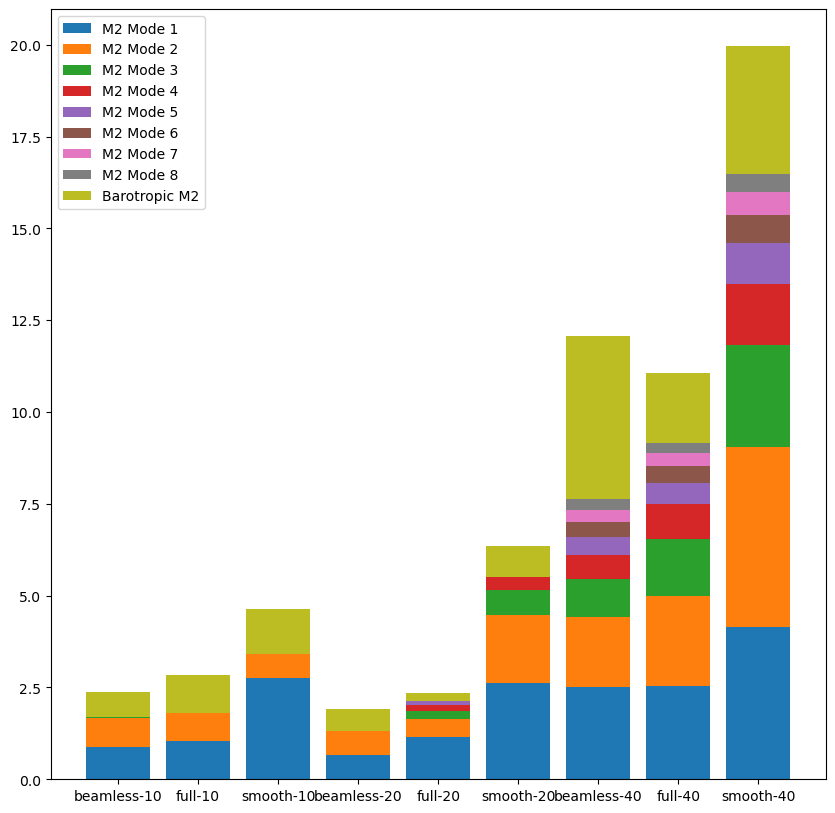

In [7]:
def ShelfMask(data):
    return data.where(
        (data.bathy > -1000) & (data.xb < 200) & (data.bathy < 0),np.nan
    )


# def ShelfMask(data):
#     return data.sel(xb = slice(600,800))

# ShelfMask(data["full-40"]).filtered_dissipation.plot()
expts = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]

total_energy = 1000 * np.array([ShelfMask(data[expt]).raw_dissipation.mean("xb").mean("yb").values for expt in expts])
mode1 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 0).mean("xb").mean("yb").values for expt in expts])
mode2 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 1).mean("xb").mean("yb").values for expt in expts])
mode3 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 2).mean("xb").mean("yb").values for expt in expts])
mode4 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 3).mean("xb").mean("yb").values for expt in expts])
mode5 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 4).mean("xb").mean("yb").values for expt in expts])
mode6 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 5).mean("xb").mean("yb").values for expt in expts])
mode7 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 6).mean("xb").mean("yb").values for expt in expts])
mode8 = 1000 * np.array([ShelfMask(data[expt]).dissipation_modal.isel(mode = 7).mean("xb").mean("yb").values for expt in expts])
barot = 1000 * np.array([
    (
        ShelfMask(data[expt]).filtered_dissipation.mean("xb").mean("yb").values - ShelfMask(data[expt].sum("mode")).dissipation_modal.mean("xb").mean("yb").values
        ) for expt in expts
    ])

notm2 = 1000 * np.array([
    (
        ShelfMask(data[expt]).raw_dissipation - ShelfMask(data[expt]).filtered_dissipation
        ).mean("xb").mean("yb").values for expt in expts
    ])

fig, ax = plt.subplots(figsize = (10,10))

bars1 = ax.bar(expts, mode1, label='M2 Mode 1')
bars2 = ax.bar(expts, mode2, bottom=mode1, label='M2 Mode 2')
bars3 = ax.bar(expts, mode3, bottom=mode1 + mode2, label='M2 Mode 3')
bars4 = ax.bar(expts, mode4, bottom=mode1 + mode2 + mode3, label='M2 Mode 4')
bars5 = ax.bar(expts, mode5, bottom=mode1 + mode2 + mode3 + mode4, label='M2 Mode 5')
bars6 = ax.bar(expts, mode6, bottom=mode1 + mode2 + mode3 + mode4 + mode5, label='M2 Mode 6')
bars7 = ax.bar(expts, mode7, bottom=mode1 + mode2 + mode3 + mode4 + mode5 + mode6, label='M2 Mode 7')
bars8 = ax.bar(expts, mode8, bottom=mode1 + mode2 + mode3 + mode4 + mode5 + mode6 + mode7, label='M2 Mode 8')
bars9 = ax.bar(expts, barot, bottom=mode1 + mode2 + mode3 + mode4 + mode5 + mode6 + mode7 + mode8, label='Barotropic M2')
# bars10 = ax.bar(expts,notm2, bottom=mode1 + mode2 + mode3 + mode4 + mode5 + mode6 + mode7 + mode8 + barot, label='Non M2')
# bars6 = ax.bar(expts, non_m2, bottom=mode1 + mode2 + mode3 + mode4 + remaining_modes, label='Non M2')
ax.legend()



In [134]:
barot

In [70]:
def ShelfMask(data):
    return data.where(
        (data.bathy > -1000) & (data.xb < 200) & (data.bathy < 0),np.nan
    )

# ShelfMask(data["full-40"]).filtered_dissipation.plot()
expts = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]

total_energy = 1000 * np.array([ShelfMask(data[expt]).raw_dissipation.mean("xb").mean("yb").values for expt in expts])
filtered_energy = 1000 * np.array([ShelfMask(data[expt]).filtered_dissipation.mean("xb").mean("yb").values for expt in expts])


fig, ax = plt.subplots(figsize = (10,10))

bars1 = ax.bar(expts, filtered_energy, label='Total Energy')
bars2 = ax.bar(expts, total_energy - filtered_energy, bottom=filtered_energy, label='Filtered Energy')
# bars6 = ax.bar(expts, non_m2, bottom=mode1 + mode2 + mode3 + mode4 + remaining_modes, label='Non M2')
ax.legend()



In [111]:
print(ShelfMask(data["beamless-40"]).sel(xb = slice(0,250)).filtered_dissipation.mean("xb").mean("yb").values)
print(ShelfMask(data["full-40"]).sel(xb = slice(0,250)).filtered_dissipation.mean("xb").mean("yb").values)

In [132]:
def ShelfMask(data):
    return data.where(
        (data.bathy > -1000) & (data.xb < 200) & (data.bathy < 0),np.nan
    )

for i in ["beamless-40","full-40","smooth-40","beamless-20","smooth-20"]:
    print(i)
    sum_modes = ShelfMask(data[i].sum("mode")).sel(xb = slice(0,250)).dissipation_modal
    filtered_diss = ShelfMask(data[i]).sel(xb = slice(0,250)).filtered_dissipation
    print(np.round(1000 * (sum_modes.mean("xb").mean("yb").values - filtered_diss.mean("xb").mean("yb").values), 5))
    # print(np.round(filtered_diss.mean("xb").mean("yb").values, 5))
    sum_modes.mean("xb").plot()
    filtered_diss.mean("xb").plot()
    plt.title(i)
    plt.figure()
    print()
    # print(filtered_diss.mean("xb").mean("yb").values)

In [109]:

ShelfMask(data["beamless-40"]).sel(xb = slice(0,250)).dissipation_modal.isel(mode = 6).mean("xb").plot()
# plt.figure()
ShelfMask(data["full-40"]).sel(xb = slice(0,250)).dissipation_modal.isel(mode = 6).mean("xb").plot()

In [69]:
(
        ShelfMask(data["beamless-40"]).filtered_dissipation - ShelfMask(data["beamless-40"].sum("mode")).dissipation_modal
        ).sel(xb = slice(0,200),yb = slice(-50,50)).plot()
plt.figure()
(
        ShelfMask(data["beamless-20"]).filtered_dissipation - ShelfMask(data["beamless-20"].sum("mode")).dissipation_modal
        ).sel(xb = slice(0,200),yb = slice(-50,50)).plot()

In [ ]:
ShelfMask(data[expt]).raw_dissipation - ShelfMask(data[expt]).filtered_dissipation
        ).mean("xb").mean("yb")

In [62]:
mode1 = ShelfMask(data["beamless-40"]).dissipation_modal.isel(mode = 0).sel(xb = slice(50,250))

mode2 = ShelfMask(data["beamless-40"]).dissipation_modal.isel(mode = 0).sel(xb = slice(50,250))
all = ShelfMask(data["beamless-40"].sum("mode")).dissipation_modal.sel(xb = slice(50,250))
(all).plot()
# (mode1).plot()

In [81]:
print(ShelfMask(
    data["full-40"]
    ).filtered_dissipation.mean("xb").mean("yb").values)
print(ShelfMask(
    data["beamless-40"]
    ).filtered_dissipation.mean("xb").mean("yb").values)
print(ShelfMask(
    data["smooth-40"]
    ).filtered_dissipation.mean("xb").mean("yb").plot)
